In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import netket as nk
import numpy as np
import jax.numpy as jnp

from netket.operator.spin import sigmax, sigmay, sigmaz

import sys 
sys.path.append('/scratch/samiz/GPU_ViT_Calcs/models')

from Afm_Model_functions import *
from vmc_2spins_sampler import Exchange_OP
import  ViT_2d_Vers3_XavierUniform as vitX 

import pickle

import jax
import matplotlib.pyplot as plt


from Structure_Factor import *

In [2]:
L = 4

# hi2d = nk.hilbert.Spin(s=0.5, N=L**2, constraint=Mtot_Parity_Constraint(parity=0))
TriGraph = nk.graph.Triangular(extent = [L,L], pbc = True)

pHa = {
    'L': L,
    'J1' : 1.0,
    'J2' : 0.4375,
    'Dxy': 0.75,
    'd' : 0.1,
    'dprime' : 0.5,
    'sublattice': [0,1,2,3,8,9,10,11]
}

Ha16, hi2d = H_afmJ123(L=pHa['L'], J1=pHa['J1'], J2=pHa['J2'], J3=pHa['J2'], Dxy=pHa['Dxy'], d=pHa['d'], dprime=pHa['dprime'], return_space=True, parity=0., sublattice = None, make_rotation=False, exchange_XY=False)
print('the Hilbert space is: ', hi2d)
XX = Exchange_OP(hi2d, TriGraph)

sa_Ha = nk.sampler.MetropolisHamiltonian(hilbert=hi2d, hamiltonian=XX, n_chains=32, sweep_size = 3* hi2d.size)
sa_ex = nk.sampler.MetropolisExchange(hilbert=hi2d, graph=TriGraph, n_chains=32, sweep_size=3*hi2d.size)
rules5050 = nk.sampler.rules.MultipleRules(rules = [sa_Ha.rule, sa_ex.rule], probabilities = [0.5, 0.5])

sa_HaEx5050 = nk.sampler.MetropolisSampler(hi2d, rules5050, n_chains=32, sweep_size=3*hi2d.size)



the Hilbert space is:  Spin(s=1/2, N=16, ordering=inverted, <vmc_2spins_sampler.Mtot_Parity_Constraint object at 0x7f3ec0238790>)


In [4]:
vs_rbm = nk.vqs.MCState(sampler = sa_HaEx5050, model = nk.models.RBM(alpha=4, param_dtype=complex), n_samples=2**12, n_discard_per_chain=16)

with open('log_HaEx5050_rbm_alpha4.0.pickle', 'rb') as handle:
    params = pickle.load(handle)

vs_rbm.variables = params

In [5]:
for _ in range(4):
    vs_rbm.sample()
    vs_rbm.reset()

In [20]:
ks = jnp.linspace(-1.1, 1.1, 400) * 4 * jnp.pi / 3
k_grid = Momentum_Grid(ks)
diffs = Create_Differences(TriGraph)
SS_Vec = Create_SpinSpin_Vec(vs_rbm, hi2d, TriGraph)

In [21]:
Sq_rbm = jax.vmap(Single_Struc_Fac, in_axes=(0, None, None, None))(k_grid, diffs, SS_Vec, hi2d.size)

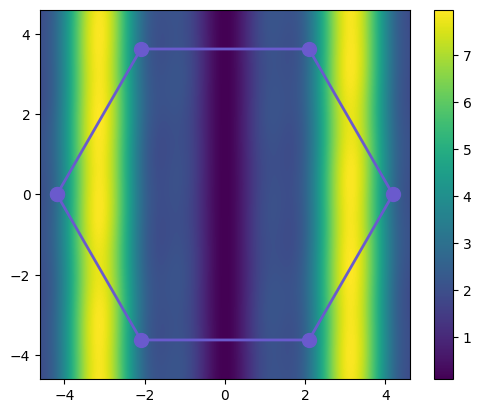

In [23]:
plt.imshow(Sq_rbm.reshape((400, 400)).real.T, extent=[ks.min(), ks.max(), ks.min(), ks.max()], cmap='viridis')
pi = np.pi
nodes = [
    (-4*pi/3, 0),  # Leftmost node
    (-2*pi/3, -2*pi/np.sqrt(3)),  # Bottom left
    (2*pi/3, -2*pi/np.sqrt(3)),  # Bottom right
    (4*pi/3, 0),  # Rightmost node
    (2*pi/3, 2*pi/np.sqrt(3)),  # Top right
    (-2*pi/3, 2*pi/np.sqrt(3)),  # Top left
    (-4*pi/3, 0)  # Close the hexagon by repeating the first node
]

# Extract x and y coordinates
x_coords, y_coords = zip(*nodes)

plt.plot(x_coords, y_coords, 'o', color='slateblue', linestyle='-', linewidth=2, markersize=10)
plt.colorbar()
plt.show()

#### Now try it out for a bigger system e.g. 6x6 lattice

In [9]:
from netket.utils import HashableArray

L = 6

# hi2d = nk.hilbert.Spin(s=0.5, N=L**2, constraint=Mtot_Parity_Constraint(parity=0))
TriGraph36 = nk.graph.Triangular(extent = [L,L], pbc = True)

pHa = {
    'L': L,
    'J1' : 1.0,
    'J2' : 0.4375,
    'Dxy': 0.75,
    'd' : 0.1,
    'dprime' : 0.5,
    'sublattice': [0,1,2,3,8,9,10,11]
}

Ha36, hi2d36 = H_afmJ123(L=pHa['L'], J1=pHa['J1'], J2=pHa['J2'], J3=pHa['J2'], Dxy=pHa['Dxy'], d=pHa['d'], dprime=pHa['dprime'], return_space=True, parity=0., sublattice = None, make_rotation=False, exchange_XY=False)
print('the Hilbert space is: ', hi2d36)
XX36= Exchange_OP(hi2d36, TriGraph36)

sa_Ha36 = nk.sampler.MetropolisHamiltonian(hilbert=hi2d36, hamiltonian=XX36, n_chains=32, sweep_size = 3* hi2d36.size)
sa_ex36 = nk.sampler.MetropolisExchange(hilbert=hi2d36, graph=TriGraph36, n_chains=32, sweep_size=3*hi2d36.size)
rules5050_36 = nk.sampler.rules.MultipleRules(rules = [sa_Ha36.rule, sa_ex36.rule], probabilities = [0.5, 0.5])

sa_HaEx5050_36 = nk.sampler.MetropolisSampler(hi2d36, rules5050_36, n_chains=32, sweep_size=3*hi2d36.size)

pVit = {
    'd': 24,
    'h': 6,
    'nl': 1,
    'Dtype': jnp.float64,
    'hidden_density': 1,
    'L': L,
    'Cx': 2,
    'Cy': 2,
    'patch_arr': HashableArray(jnp.array([[0,1,6,7], [2,3,8,9], [4,5,10,11],
                                           [12,13,18,19], [14,15,20,21], [16,17,22,23],
                                             [24,25,30,31], [26,27,32,33], [28,29,34,35]])),
}

m_Vit = vitX.ViT_2d(patch_arr=HashableArray(pVit['patch_arr']), embed_dim=pVit['d'], num_heads=pVit['h'], nl=pVit['nl'],
                                Dtype=pVit['Dtype'], L=pVit['L'], Cx=pVit['Cx'], Cy=pVit['Cy'], hidden_density=pVit['hidden_density'])



vs_vit = nk.vqs.MCState(sampler=sa_HaEx5050_36, model=m_Vit, n_samples=2**12, n_discard_per_chain=16)
with open('log_vit_sampler_HaEx_5050.pickle', 'rb') as handle:
    params = pickle.load(handle)

vs_vit.variables = params



the Hilbert space is:  Spin(s=1/2, N=36, ordering=inverted, <vmc_2spins_sampler.Mtot_Parity_Constraint object at 0x7f6984447690>)


In [10]:
for _ in range(4):
    vs_vit.sample()
    vs_vit.reset()

In [11]:
vs_vit.expect(Ha36)

-54.820-0.001j ± 0.012 [σ²=0.553, R̂=1.0033]

In [12]:
ks = jnp.linspace(-1.1, 1.1, 400) * 4 * jnp.pi / 3
k_grid = Momentum_Grid(ks)
diffs = Create_Differences(TriGraph36)
SS_Vec36 = Create_SpinSpin_Vec(vs_vit, hi2d36, TriGraph36)

In [13]:
Sq_vit = jax.vmap(Single_Struc_Fac, in_axes=(0, None, None, None))(k_grid, diffs, SS_Vec36, hi2d36.size)

2025-03-28 15:07:14.269605: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3020] Can't reduce memory use below 1.79GiB (1917832396 bytes) by rematerialization; only reduced to 3.09GiB (3317760000 bytes), down from 3.09GiB (3317760000 bytes) originally


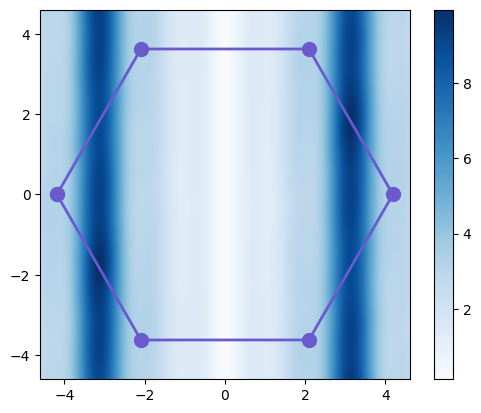

In [17]:
plt.imshow(Sq_vit.reshape((400, 400)).real.T, extent=[ks.min(), ks.max(), ks.min(), ks.max()], cmap='Blues')
pi = np.pi
nodes = [
    (-4*pi/3, 0),  # Leftmost node
    (-2*pi/3, -2*pi/np.sqrt(3)),  # Bottom left
    (2*pi/3, -2*pi/np.sqrt(3)),  # Bottom right
    (4*pi/3, 0),  # Rightmost node
    (2*pi/3, 2*pi/np.sqrt(3)),  # Top right
    (-2*pi/3, 2*pi/np.sqrt(3)),  # Top left
    (-4*pi/3, 0)  # Close the hexagon by repeating the first node
]

# Extract x and y coordinates
x_coords, y_coords = zip(*nodes)

plt.plot(x_coords, y_coords, 'o', color='slateblue', linestyle='-', linewidth=2, markersize=10)
plt.colorbar()
plt.show()